In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime as dt
from pandas_datareader import DataReader as DR
import seaborn as sb
import numdifftools as nd
from wquantiles import quantile
import statsmodels.api as sm

from scipy.stats import norm,t,truncnorm
from scipy.stats import multivariate_normal as mvnorm
from scipy.stats import multivariate_t as mvt
from scipy.spatial import Delaunay as TRI
from scipy.interpolate import LinearNDInterpolator as ITP
from scipy.optimize import minimize,root
from scipy.optimize import NonlinearConstraint as NonlinCons
from scipy.stats import gaussian_kde as sciKDE

from sklearn.linear_model import LinearRegression as Linear
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KernelDensity as sklKDE

import warnings
warnings.filterwarnings("ignore")

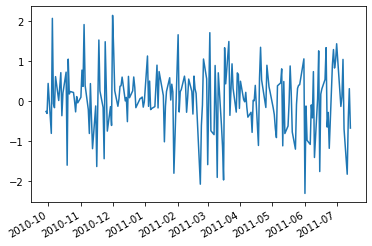

In [2]:
data=DR('^GSPC','yahoo',dt(2010,9,29),dt(2011,7,14))
returns=pd.DataFrame(100*np.diff(np.log(data['Adj Close'])),columns=['dlr'])
returns.index=data.index.values[1:data.index.values.shape[0]]

returns['dlr'].plot()
plt.show()
returns=np.array(returns['dlr'])

D=[1,2,5]
Alpha=[0.05,0.01]
Truth=np.array([[-1.333,-1.895],[-1.886,-2.771],[-2.996,-4.424]])
refavar=lambda p: (p*(1-p),4*(p*(1-p))**2)

In [3]:
class GARCH:
    def __init__(self,returns):
        self.h0=np.std(returns)
        self.y0=returns[0]
        self.YT=returns[1:]
        self.T=self.YT.size
        self.prior_pars=[-1,2]
    
    def __supp(self,H,ub=1e300):
        H[H>ub]=ub
        return H
    
    def test(self,pars):
        return (pars[:,1]>=0)&(pars[:,2]>=0)&(pars[:,1]+pars[:,2]<1)
        
    def posterior(self,pars):
        neglogpdfpT=0.5*((pars[:,0]-self.prior_pars[0])/self.prior_pars[1])**2
        H_T1=np.exp(pars[:,0])+pars[:,1]*self.y0**2+pars[:,2]*self.h0
        for i in range(self.T):
            neglogpdfpT+=0.5*(self.YT[i]**2/H_T1+np.log(H_T1))
            H_T1=np.exp(pars[:,0])+pars[:,1]*self.YT[i]**2+pars[:,2]*H_T1
        
        H_T1=self.__supp(H_T1)
        return neglogpdfpT,H_T1
    
    def laplace(self,size=1000000,df=1):
        cons=({'type':'ineq',\
               'fun':lambda pars: np.array([pars[1],pars[2],1-pars[1]-pars[2]]),\
               'jac':lambda x: np.array([[0,1,0],[0,0,1],[0,-1,-1]])})
        target=lambda pars: self.posterior(pars.reshape([1,-1]))[0]
        res=minimize(target,[0,0.1,0.7],method='SLSQP',constraints=cons,\
                     options={'maxiter':1000,'ftol':1e-100,'gtol':1e-100,'disp':False})
        mu=res['x']
        Sigma=np.linalg.inv(nd.Hessian(target)(mu))
        Sigma[:,0]*=2
        Sigma[0,:]*=2
        parsfull=lambda size: np.array([t.rvs(size=size,df=df,loc=mu[i],\
                                              scale=np.sqrt(Sigma[i,i])) for i in range(3)]).T
        pars=parsfull(size)
        trunc=self.test(pars).mean()
        print('Laplace acceptance rate: {:.2f}%'.format(100*trunc))
        def pars(size):
            pars=parsfull(int(2*size/trunc))
            good=self.test(pars)
            index=np.arange(good.sum())
            return pars[good][np.random.choice(index,size,replace=False)]
            
        def pdft(pars):
            good=self.test(pars)
            pdf=np.prod([t.pdf(x=pars[:,i],df=df,loc=mu[i],\
                             scale=np.sqrt(Sigma[i,i])) for i in range(3)],axis=0)/trunc
            return good*pdf
        
        self.pars=pars
        self.pdft=pdft
        
    def prediction(self,pars,H_Td,d,rvs=True,Yd=None):
        pdfqd=np.ones([pars.shape[0],3])
        if rvs:
            Yd=np.zeros([pars.shape[0],d])
            for i in range(d-1):
                Yd[:,i]=norm.rvs(scale=np.sqrt(H_Td))
                pdfqd[:,0]*=norm.pdf(x=Yd[:,i],scale=np.sqrt(H_Td))
                H_Td=np.exp(pars[:,0])+pars[:,1]*Yd[:,i]**2+pars[:,2]*H_Td
                H_Td=self.__supp(H_Td)
                
            half=pars.shape[0]//2
            Yd[:half,-1]=norm.rvs(scale=np.sqrt(H_Td[:half]))
            Yd[half:,-1]=norm.rvs(loc=-np.sqrt(H_Td[half:]),scale=np.sqrt(H_Td[half:]))
            pdfqd[:,1]*=norm.pdf(x=Yd[:,-1],scale=np.sqrt(H_Td))
            pdfqd[:,2]*=norm.pdf(x=Yd[:,-1],loc=-np.sqrt(H_Td),scale=np.sqrt(H_Td))
            return pdfqd,Yd
        else:
            for i in range(d-1):
                pdfqd[:,0]*=norm.pdf(x=Yd[:,i],scale=np.sqrt(H_Td))
                H_Td=np.exp(pars[:,0])+pars[:,1]*Yd[:,i]**2+pars[:,2]*H_Td
                H_Td=self.__supp(H_Td)
                
            pdfqd[:,1]*=norm.pdf(x=Yd[:,-1],scale=np.sqrt(H_Td))
            pdfqd[:,2]*=norm.pdf(x=Yd[:,-1],loc=-np.sqrt(H_Td),scale=np.sqrt(H_Td))
            return pdfqd
        
        
class MLE:
    def __init__(self,size):
        self.garch=GARCH(returns)
        self.garch.laplace(size=size)
    
    def __divi(self,p,q):
        q[p==0]=1
        return p/q

    def __estimate(self,RYd,W,name,asym=True):
        self.eVaR=quantile(RYd,W,self.alpha)
        if asym:
            w=W/np.sum(W)
            aVar=np.sum((w*(1.0*(RYd<=self.eVaR)-self.alpha))**2)*RYd.size
            ESS=1/np.sum(w**2)
            Wf=W*(RYd<self.eVaR)
            wf=Wf/np.sum(Wf)
            ESSf=1/np.sum(wf**2)
            print('{} est: {:.4f}; a-var (prob): {:.6f}; ESS: {:.0f}/{}; ESS(f): {:.0f}/{}'\
                  .format(name,self.eVaR,aVar,ESS,RYd.size,ESSf,RYd.size))
        else:
            print('{} est: {:.4f}'.format(name,self.eVaR))
            
        if any(W<0):
            W[W<0]=0
            self.eVaR=quantile(RYd,W,self.alpha)
            print('(adjusted) {} est: {:.4f}'.format(name,self.eVaR))
            
    def set_params(self,alpha,d):
        self.alpha=Alpha[alpha]
        self.d=D[d]
        self.truth=Truth[d,alpha]
        print('Reference: VaR{} (d={}): {}; a-var (prob) [direct, optimal]: {}'\
              .format(self.alpha,self.d,self.truth,np.round(refavar(self.alpha),6)))
    
    def estimate_IS(self,size,K):
        pars=self.garch.pars(size)
        pdft=self.garch.pdft(pars)
        neglogpdfpT,H_T1=self.garch.posterior(pars)
        self.Z=neglogpdfpT.min()
        neglogpdfpT-=self.Z
        pdfpT=np.exp(-neglogpdfpT)
        pdfqd,Yd=self.garch.prediction(pars,H_T1,self.d)
        pdfp=pdfpT*pdfqd[:,1]
        pdfq=pdft*pdfqd[:,1:].mean(axis=1)
        
        RYd=Yd.sum(axis=1)
        W=self.__divi(pdfp,pdfq)
        self.__estimate(RYd,W,'IS')
        
        self.iS=np.hstack([pars,Yd])
        self.T=pdfp*pdfqd[:,0]
        self.iP=pdfq*pdfqd[:,0]
        self.__resample(W,K)
        
    def __resample(self,W,size):
        index=np.arange(W.size)
        rW=W*np.abs(1.0*(self.iS[:,3:].sum(axis=1)<=self.eVaR)-self.alpha)
        self.choice=np.random.choice(index,size,p=rW/np.sum(rW))
        self.rS=self.iS[self.choice]
        self.rSset=self.iS[list(set(self.choice))]
        print('Resampling rate: {}/{}'.format(self.rSset.shape[0],size))
        
    def estimate_NIS(self,size,bdwth='scott'):
        rS1=self.rS[self.rS[:,3:].sum(axis=1)<=self.eVaR]
        rS2=self.rS[self.rS[:,3:].sum(axis=1)>self.eVaR]
        kde1=sciKDE(rS1.T,bw_method=bdwth)
        kde2=sciKDE(rS2.T,bw_method=bdwth)
        cov1=kde1.covariance_factor()*np.cov(rS1.T)
        cov2=kde2.covariance_factor()*np.cov(rS2.T)
        num1=len(set(self.choice[self.rS[:,3:].sum(axis=1)<=self.eVaR]))
        num2=len(set(self.choice[self.rS[:,3:].sum(axis=1)>self.eVaR]))
        print('KDE 1: {}/{}, bdwth: {}'.format(num1,rS1.shape[0],np.round(np.sqrt(np.diag(cov1)),2)))
        print('KDE 2: {}/{}, bdwth: {}'.format(num2,rS2.shape[0],np.round(np.sqrt(np.diag(cov2)),2)))
        
        tmp=np.copy(self.eVaR)
        h=lambda x,loc: mvnorm.pdf(x=x,mean=loc,cov=cov1 if loc[3:].sum()<=tmp else cov2)
        rate0=rS1.shape[0]/(rS1.shape[0]+rS2.shape[0])
        nP=lambda x: rate0*kde1.pdf(x.T)+(1-rate0)*kde2.pdf(x.T)
        nS=np.vstack([kde1.resample(round(rate0*size)).T,kde2.resample(size-round(rate0*size)).T])
        
        good=self.garch.test(nS[:,:3])
        pdft=self.garch.pdft(nS[:,:3])
        neglogpdfpT=np.ones(size)*np.inf
        H_T1=np.ones(size)
        neglogpdfpT[good],H_T1[good]=self.garch.posterior(nS[good,:3])
        neglogpdfpT-=self.Z
        pdfpT=np.exp(-neglogpdfpT)
        print('Samples (KDE) in feasible region: {:.2f}%'.format(100*np.mean(good)))
        
        pdfqd=np.zeros([size,3])
        pdfqd[good]=self.garch.prediction(nS[good,:3],H_T1[good],self.d,rvs=False,Yd=nS[good,3:])
        T=pdfpT*pdfqd[:,0]*pdfqd[:,1]
        iP=pdft*pdfqd[:,0]*pdfqd[:,1:].mean(axis=1)
        
        mS=np.vstack([self.iS,nS])
        self.T=np.append(self.T,T)
        iP=np.append(self.iP,iP)
        rate=np.array([self.iS.shape[0],size])/(self.iS.shape[0]+size)
        self.mP=rate.dot([iP,nP(mS)])
        
        self.RYd=mS[:,3:].sum(axis=1)
        W=self.__divi(self.T,self.mP)
        self.__estimate(self.RYd,W,'NIS')
        self.G=np.array([h(mS,loc) for loc in self.rSset[1:]])-nP(mS)
        
    def estimate_RIS(self):
        X=(self.G/self.mP).T
        tmp=X/np.linalg.norm(X,axis=0)
        lbd=np.linalg.eigvals(tmp.T.dot(tmp))
        tau=np.sqrt(lbd.max()/lbd)
        print('Condition index: (min {:.4f}, median {:.4f}, mean {:.4f}, max {:.4f} (second {:.4f}), [>30] {}/{})'\
              .format(tau.min(),np.median(tau),tau.mean(),tau.max(),tau[tau!=tau.max()].max(),np.sum(tau>30),tau.size))
        
        y2=self.__divi(self.T,self.mP)
        y1=y2*(self.RYd<=self.eVaR)
        y3=y1-self.alpha*y2
        self.reg1=Linear().fit(X,y1)
        self.reg2=Linear().fit(X,y2)
        self.reg3=Linear().fit(X,y3)
        print('Tail R2: {:.4f}; Body R2: {:.4f}; Overall R2: {:.4f}'\
              .format(self.reg1.score(X,y1),self.reg2.score(X,y2),self.reg3.score(X,y3)))
        
        W2=y2-X.dot(self.reg2.coef_)
        W3=y3-X.dot(self.reg3.coef_)
        aVar=(np.sum(W3**2)/(np.sum(W2))**2)*W2.size
        print('RIS a-var (prob): {:.6f}'.format(aVar))

    def estimate_MLE(self,opt=True,NR=True):
        mP=self.mP
        G=self.G
        target=lambda zeta: -np.mean(np.log(mP+zeta.dot(G)))
        gradient=lambda zeta: -np.mean(G/(mP+zeta.dot(G)),axis=1)
        hessian=lambda zeta: (G/(mP+zeta.dot(G))**2).dot(G.T)/G.shape[1]
        zeta0=np.zeros(G.shape[0])
        grad0=gradient(zeta0)
        print('MLE reference:')
        print('origin: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
              .format(target(zeta0),grad0.min(),grad0.mean(),grad0.max(),grad0.std()))
        
        print()
        print('Theoretical results:')
        X=(G/mP).T
        XX=X-X.mean(axis=0)
        zeta1=np.linalg.solve(XX.T.dot(XX),X.sum(axis=0))
        print('MLE(The) zeta: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f}, norm {:.4f})'\
              .format(zeta1.min(),zeta1.mean(),zeta1.max(),zeta1.std(),np.sqrt(np.sum(zeta1**2))))
        grad1=gradient(zeta1)
        print('theory: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
              .format(target(zeta1),grad1.min(),grad1.mean(),grad1.max(),grad1.std()))
        W=(self.T/mP)*(1-XX.dot(zeta1))
        W=W/W.mean()
        print('reg weights: (min {:.4f}, mean {:.4f}, max {:.4f}, [<0] {}/{})'\
              .format(W.min(),W.mean(),W.max(),np.sum(W<0),W.size))
        self.__estimate(self.RYd,W,'RIS',asym=False)
        W=self.T/(mP+zeta1.dot(G))
        W=W/W.mean()
        print('mle weights (The): (min {:.4f}, mean {:.4f}, max {:.4f}, [<0] {}/{})'\
              .format(W.min(),W.mean(),W.max(),np.sum(W<0),W.size))
        self.__estimate(self.RYd,W,'MLE(The)',asym=False)
        
        if opt:
            zeta=zeta1 if target(zeta1)!=np.nan else zeta0
            begin=dt.now()
            if NR:
                res=root(lambda zeta: (gradient(zeta),hessian(zeta)),zeta,method='lm',jac=True)
            else:
                cons=({'type':'ineq','fun':lambda zeta: mP+zeta.dot(G),'jac':lambda zeta: G.T})
                res=minimize(target,zeta,method='SLSQP',jac=gradient,constraints=cons,\
                             options={'ftol':1e-8,'maxiter':1000})
            
            end=dt.now()
            print()
            print('Optimization results (spent {} seconds):'.format((end-begin).seconds))
            if res['success']:
                zeta=res['x']
                print('MLE(Opt) zeta: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f}, norm {:.4f})'\
                      .format(zeta.min(),zeta.mean(),zeta.max(),zeta.std(),np.sqrt(np.sum(zeta**2))))
                print('Dist(zeta(Opt),zeta(The))={:.4f}'.format(np.sqrt(np.sum((zeta-zeta1)**2))))
                grad=gradient(zeta)
                print('optimal: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
                      .format(target(zeta),grad.min(),grad.mean(),grad.max(),grad.std()))
                W=self.T/(mP+zeta.dot(G))
                W=W/W.mean()
                print('mle weights (Opt): (min {:.4f}, mean {:.4f}, max {:.4f}, [<0] {}/{})'\
                      .format(W.min(),W.mean(),W.max(),np.sum(W<0),W.size))
                self.__estimate(self.RYd,W,'MLE(Opt)',asym=False)
            else:
                print('MLE fail')

In [4]:
mle=MLE(size=10000000)

Laplace acceptance rate: 48.15%


In [5]:
mle.set_params(alpha=0,d=1)
print('====================================================')
mle.estimate_IS(size=1000000,K=1000)

Reference: VaR0.05 (d=2): -1.886; a-var (prob) [direct, optimal]: [0.0475   0.009025]
IS est: -1.8989; a-var (prob): 1.854899; ESS: 13712/1000000; ESS(f): 1345/1000000
Resampling rate: 913/1000


In [6]:
data=pd.DataFrame(mle.rS,columns=['phi0','phi1','beta','y1','y2'])
data['tail']=(mle.rS[:,3:].sum(axis=1)<=mle.eVaR)

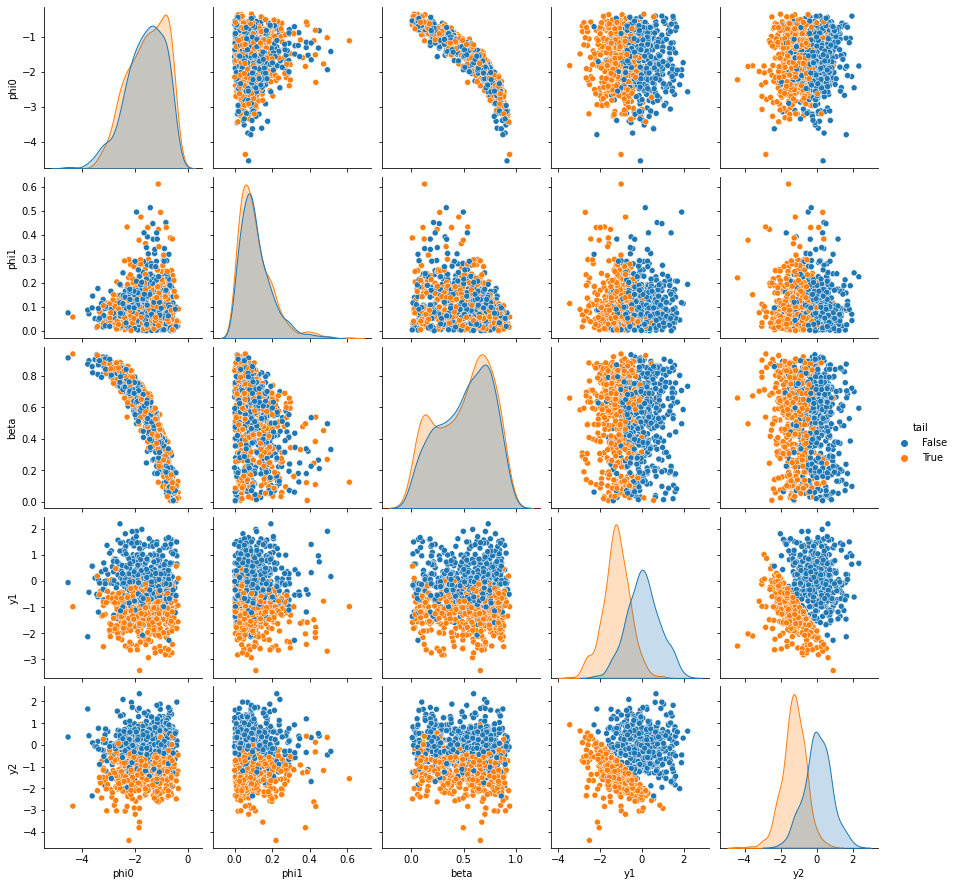

In [7]:
sb.pairplot(data,hue='tail')
plt.show()